In [8]:
import temporian as tp

import pandas as pd
import numpy as np

In [9]:
# Generate a synthetic dataset
timestamps = np.arange(0, 100, 0.1)
n = len(timestamps)
noise = 0.1 * np.random.randn(n)
trend = 0.01 * timestamps
season = 0.4 * np.sin(0.5 * timestamps)

raw_data = pd.DataFrame(
    {
        "timestamp": timestamps,
        # "noise": noise,
        # "trend": trend,
        # "seasoon": season,
        "signal": noise + trend + season,
    }
)

raw_data

,timestamp,signal
0,0.0,-0.030399
1,0.1,0.061535
2,0.2,0.019175
3,0.3,0.185146
4,0.4,0.115204
...,...,...
995,99.5,0.900765
996,99.6,0.837335
997,99.7,0.781860
998,99.8,0.995522


In [10]:
# Convert the dataset into a Temporian dataset

source_data = tp.EventData.from_dataframe(raw_data)

source_data

data (1):
    ():
        signal <FLOAT64> (1000): [-0.0304  0.0615  0.0192 ...  0.7819  0.9955  0.86  ]
sampling:
    index: []
    data (1):
        () (1000): [ 0.   0.1  0.2 ... 99.7 99.8 99.9]

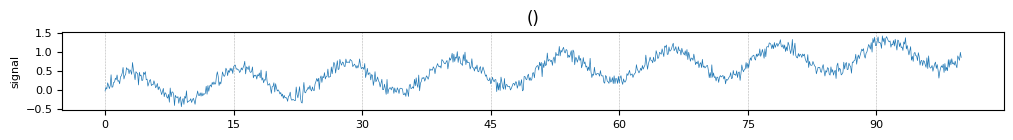

In [11]:
# Plot the dataset
_ = source_data.plot()

In [12]:
# Compute some signals
source = source_data.schema()

signal = source["signal"]
trend =  tp.simple_moving_average(signal, 50)
detrend = signal - trend
trend2 = tp.simple_moving_average(detrend, 10)
detrend2 = detrend - trend2
slope =  trend2 - tp.sample(tp.lag(trend2, 5), trend2)

result = tp.glue(
    signal,
    tp.prefix("trend.", trend),
    tp.prefix("detrend.", detrend),
    tp.prefix("trend2.", trend2),
    tp.prefix("detrend2.", detrend2),
    tp.prefix("slope.", slope),
)

result_data = tp.evaluate(result, {source: source_data})

result_data

Build schedule
Run 14 operators
    1 / 14: SELECT [0.00007 s]
    2 / 14: SIMPLE_MOVING_AVERAGE [0.00006 s]
    3 / 14: SUBTRACTION [0.00007 s]
    4 / 14: PREFIX [0.00002 s]
    5 / 14: SIMPLE_MOVING_AVERAGE [0.00004 s]
    6 / 14: PREFIX [0.00002 s]
    7 / 14: PREFIX [0.00002 s]
    8 / 14: SUBTRACTION [0.00006 s]
    9 / 14: PREFIX [0.00002 s]
    10 / 14: LAG [0.00007 s]
    11 / 14: SAMPLE [0.00013 s]
    12 / 14: SUBTRACTION [0.00006 s]
    13 / 14: PREFIX [0.00002 s]
    14 / 14: GLUE [0.00005 s]
Execution in 0.00250 s


data (1):
    ():
        signal <FLOAT64> (1000): [-0.0304  0.0615  0.0192 ...  0.7819  0.9955  0.86  ]
        trend.signal <FLOAT64> (1000): [-0.0304  0.0156  0.0168 ...  0.7577  0.7592  0.76  ]
        detrend.sub_signal_signal <FLOAT64> (1000): [0.     0.046  0.0024 ... 0.0241 0.2364 0.1001]
        trend2.sub_signal_signal <FLOAT64> (1000): [0.     0.023  0.0161 ... 0.2166 0.2116 0.2075]
        detrend2.sub_sub_signal_signal_sub_signal_signal <FLOAT64> (1000): [ 0.      0.023  -0.0137 ... -0.1925  0.0248 -0.1074]
        slope.sub_sub_signal_signal_lag[5s]_sub_signal_signal <FLOAT64> (1000): [    nan     nan     nan ... -0.0992 -0.1063 -0.114 ]
sampling:
    index: []
    data (1):
        () (1000): [ 0.   0.1  0.2 ... 99.7 99.8 99.9]

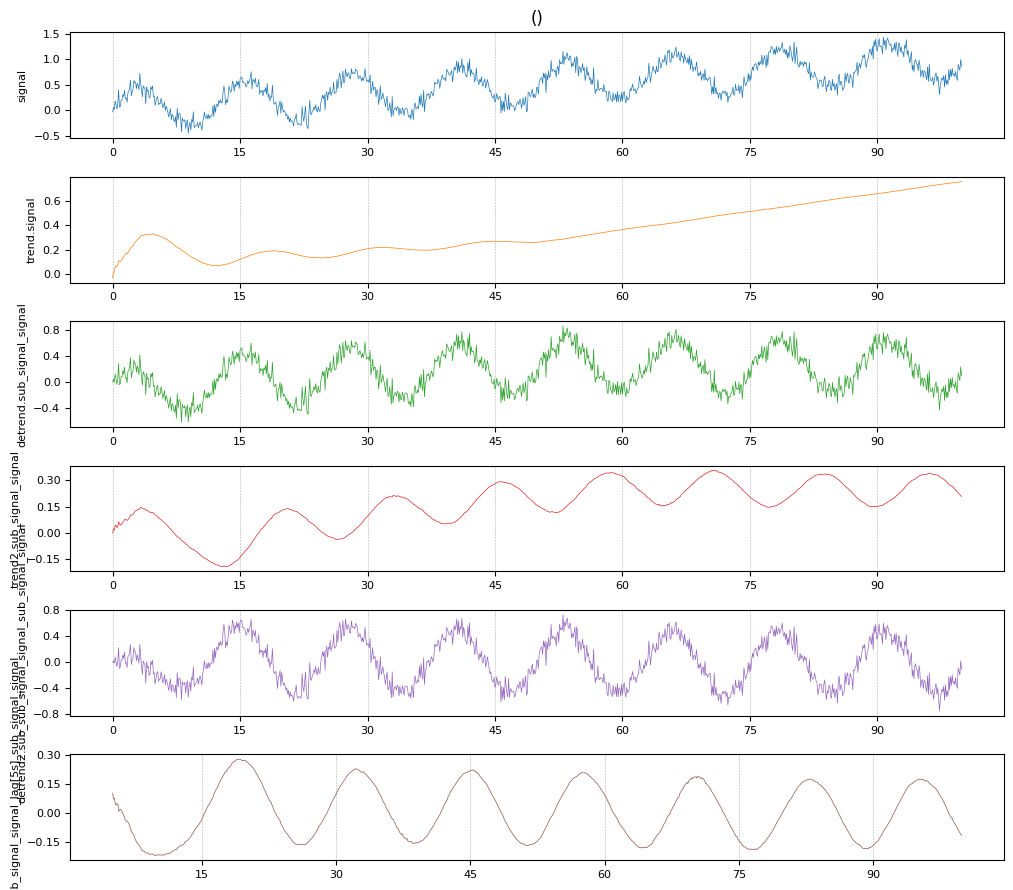

In [13]:
# Plot the results
_ = result_data.plot()